# Model training, deploying and making on-chain prediction

This notebook includes information on how to prepare (load and transform) your data to train a deep neural network, deploy the model on-chain and how to use it. We split the content into:
1. Train the model using a wide-known dataset, official dataset supported by tensorflow, or keras.
2. Train the model using a custom visual dataset.
3. Deploy on-chain models.
4. Make prediction.

### Data preparation

In general, the target of data preparation step is to create sample data and groundtruth (X, y). By best practice, a dataset should be split into train (ratio%) and validation ((1 - ratio)%) subsets for training and validating progress. Let's clarify first the final artifact of this step:
- Training set: include X_train, y_train
- Validation set: include X_val, y_val

**The ratio of samples between validation and training set is up to you!** 

## 0. Requirement

Some dependencies need to be installed first:
- numpy 
- opencv-python
- tensorflow==2.16.1
- keras
- matplotlib (for visualization)
- tqdm (for progress bar)

Run:

In [1]:
!python -m pip install opencv-python tensorflow==2.16.1 matplotlib tqdm gdown

Then, make sure all of them are imported on your script file:

In [1]:
import numpy as np
import os
import keras
from keras import layers

2024-07-22 07:53:44.106015: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 07:53:44.110145: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 07:53:44.166317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now, let's define model factories for trying in the next sections

In [3]:
# create lenet 5 architecture for classification
def create_lenet5_for_classification(input_shape, num_classes, dense_cfg=[]):
    return keras.Sequential(
        [
            layers.InputLayer(shape=input_shape),
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            *[layers.Dense(units, activation="relu") for units in dense_cfg],
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

# Create a simple MLP model for classification
def create_mlp(input_shape, dense_cfg=[]):
    return keras.Sequential(
        [
            layers.InputLayer(shape=input_shape),
            layers.Flatten(),
            *[layers.Dense(units, activation="relu") for units in dense_cfg],
            layers.Dense(10, activation="softmax"),
        ]
    )

## 1. Train the model using a wide-known dataset

Tensorflow and keras provide us instant API for loading the data as numpy data, sometime already normalized. These APIs help us to quick try a model architecture on a standard dataset to solve a common problem. For instant, I want to use MNIST dataset, for practice purpose, then:

In [2]:
# load the preprocessed dataset from keras
mnist_data = keras.datasets.mnist.load_data()

In [3]:
# mnist_data has format (x_train, y_train), (x_test, y_test), now we unpack it
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data 
print('Shape:', mnist_x_train.shape, mnist_y_train.shape, mnist_x_test.shape, mnist_y_test.shape)

Shape: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
# mnist dataset has labels for 10 classes are 10 digits, from 0-9
mnist_labels = [str(i) for i in range(10)]

# mnist dataset by keras is shaped [28, 28] each item, has value range in [0, 255].
# then, we have to transform and normalize it before usage 
mnist_x_train = mnist_x_train.astype(np.float32) / 255.0 
mnist_x_test = mnist_x_test.astype(np.float32) / 255.0

# the operation is actually max, min scale. but the max is always 255 and the min value is always 0,
# so we just need to divide the x_train and x_test by 255 in this case
# for other tasks, it should be: x_norm = (x - min) / (max - min)

print('x_train\'s value range:', mnist_x_train.min(), mnist_x_train.max())
print('x_test\'s value range:', mnist_x_test.min(), mnist_x_test.max())

x_train's value range: 0.0 1.0
x_test's value range: 0.0 1.0


In [5]:
# as the standard, input of keras model must includes one channel dim. 
# So, we need to expand the last dimension to form a pseudo channel dim

mnist_x_train = np.expand_dims(mnist_x_train, -1) # -1 is the last dim
mnist_x_test = np.expand_dims(mnist_x_test, -1) # -1 is the last dim

print('Shape:', mnist_x_train.shape, mnist_y_train.shape, mnist_x_test.shape, mnist_y_test.shape)

Shape: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [6]:
# In total, we have

print(mnist_x_train.shape[0], 'training samples.')
print(mnist_x_test.shape[0], 'testing samples.')

60000 training samples.
10000 testing samples.


In [9]:
# now create a lenet model and try it

lenet5_mnist = create_lenet5_for_classification(
    mnist_x_train.shape[1:], 
    len(mnist_labels)
)

lenet5_mnist.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lenet5_mnist.summary()

2024-07-22 06:54:43.514847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-22 06:54:43.516353: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,098 (35.54 KB)

 Trainable params: 9,098 (35.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# train the model 

lenet5_mnist.fit(
    mnist_x_train, 
    keras.utils.to_categorical(
        mnist_y_train, 
        len(mnist_labels)
    ),
    batch_size=128, # my pc is strong so i set it to 128. it should be lower for weaker pc
    epochs=5, 
    validation_split=0.1 # validation directly on the train set. notice that the train set will be separated into 2 parts: train and validation
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5203 - loss: 0.2735 - val_accuracy: 0.9505 - val_loss: 0.0425
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9500 - loss: 0.0423 - val_accuracy: 0.9723 - val_loss: 0.0256
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9677 - loss: 0.0277 - val_accuracy: 0.9803 - val_loss: 0.0194
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9733 - loss: 0.0222 - val_accuracy: 0.9853 - val_loss: 0.0161
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9793 - loss: 0.0183 - val_accuracy: 0.9863 - val_loss: 0.0149


In [13]:
# eval on test set

test_loss, test_acc = lenet5_mnist.evaluate(
    mnist_x_test,
    keras.utils.to_categorical(
        mnist_y_test,
        len(mnist_labels)
    )
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9777 - loss: 0.0186
Test accuracy: 0.9821000099182129
Test loss: 0.015978699550032616


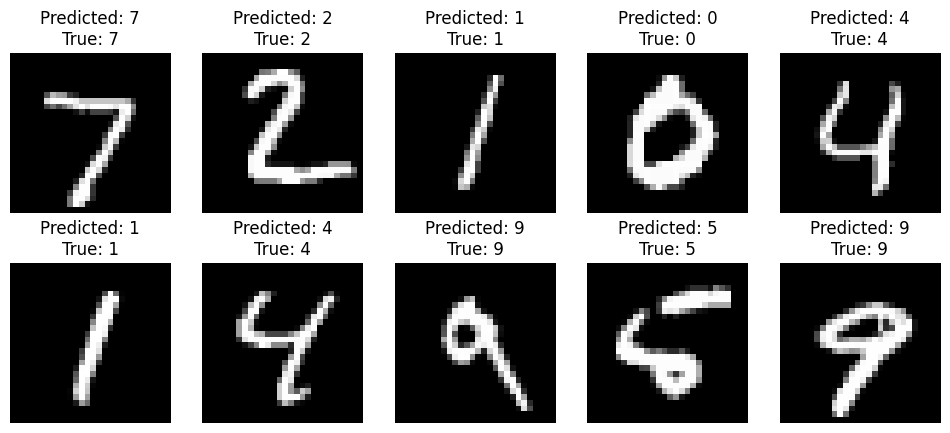

In [14]:
# visualize the result

from matplotlib import pyplot as plt 

n = 10
plt.figure(figsize=(12, 5))
for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Predicted: {}\nTrue: {}'.format(
        mnist_labels[np.argmax(lenet5_mnist.predict(mnist_x_test[i:i+1], verbose=None))],
        mnist_labels[mnist_y_test[i]]
    ))
    plt.axis('off')
plt.show()


looks good!

In [27]:
lenet5_mnist.save('lenet5_mnist.keras')

## 2. Train the model using a custom visual dataset

This section is to help you create a training data for a specific task. The sample I use is to categorize dog and cat images using lenet5 model.

In [15]:
# at first, download it from the gdrive id
# install gdown: python -m pip install gdown

if not os.path.exists('cat-dog.zip'):
    !gdown  1FP3NB3diInw-kIno5aU3w7DAZUaKFWla -O cat-dog.zip

    import zipfile

    assert os.path.exists('cat-dog.zip'), 'File not found'
    with zipfile.ZipFile('cat-dog.zip', 'r') as zip_ref:
        zip_ref.extractall('cat-dog-dataset')

Downloading...
From (original): https://drive.google.com/uc?id=1FP3NB3diInw-kIno5aU3w7DAZUaKFWla
From (redirected): https://drive.google.com/uc?id=1FP3NB3diInw-kIno5aU3w7DAZUaKFWla&confirm=t&uuid=6529cdf5-3584-471f-911f-c50dbb1606ab
To: /home/xxx/dev-eternalai/data/cat-dog.zip
100%|████████████████████████████████████████| 570M/570M [00:22<00:00, 25.7MB/s]


In [4]:
# the train data file has fmt label.<id>.jpg
# now define a function to load it

import re, cv2, glob

pattern = re.compile(r'(\w+)\.(\d+)\.jpg')

labels_map = {
    'cat': 0,
    'dog': 1
}

def load_item(path):
    name = os.path.split(path)[-1]
    label, _ = pattern.match(name).groups()
    return cv2.imread(path), labels_map[label]

In [5]:
# index data files, load and split 

train_files = glob.glob('cat-dog-dataset/train/*.jpg')
print('Total data files:', len(train_files)) 

train_ratio = .7
train_files = np.random.permutation(train_files)

train_files = train_files[:int(len(train_files) * train_ratio)]
val_files = train_files[int(len(train_files) * train_ratio):]

print('Train files:', len(train_files))
print('Validation files:', len(val_files))

Total data files: 25000
Train files: 17500
Validation files: 5250


In [6]:
# now we load and transform data manually

catdog_x_train, catdog_y_train, catdog_x_test, catdog_y_test = [], [], [], []
img_input_size = (64, 64) # we use larger image for this task


In [7]:
import tqdm 

for path in tqdm.tqdm(train_files, desc='Loading train data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    catdog_x_train.append(x)
    catdog_y_train.append(y)

    rgb = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    catdog_x_train.append(rgb)
    catdog_y_train.append(y)

for path in tqdm.tqdm(val_files, desc='Loading validation data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    catdog_x_test.append(x)
    catdog_y_test.append(y)

# construct np.arrays for the next steps
catdog_x_train = np.array(catdog_x_train)
catdog_y_train = np.array(catdog_y_train)
catdog_x_test = np.array(catdog_x_test)
catdog_y_test = np.array(catdog_y_test)

print('Shape:', catdog_x_train.shape, catdog_y_train.shape, catdog_x_test.shape, catdog_y_test.shape)

Loading validation data: 100%|██████████| 5250/5250 [00:04<00:00, 1305.37it/s]


Shape: (35000, 64, 64, 3) (35000,) (5250, 64, 64, 3) (5250,)


In [8]:
# now normalize the data

catdog_x_train = catdog_x_train.astype(np.float32) / 255.0
catdog_x_test = catdog_x_test.astype(np.float32) / 255.0

In [9]:
print('Value range:', catdog_x_train.min(), catdog_x_train.max(), catdog_x_test.min(), catdog_x_test.max())
print('Shape:', catdog_x_train.shape, catdog_y_train.shape, catdog_x_test.shape, catdog_y_test.shape)

Value range: 0.0 1.0 0.0 1.0
Shape: (35000, 64, 64, 3) (35000,) (5250, 64, 64, 3) (5250,)


In [22]:
# create a lenet model 
# in this task, the input is 3-channel image, so we have to change the input shape

lenet5_catdog = create_lenet5_for_classification(
    catdog_x_train.shape[1:],
    len(labels_map),
    dense_cfg=[64]
)

lenet5_catdog.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lenet5_catdog.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,730 (1.01 MB)

 Trainable params: 263,730 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# train the model

lenet5_catdog.fit(
    catdog_x_train,
    keras.utils.to_categorical(catdog_y_train, len(labels_map)),
    batch_size=128,
    epochs=10,
    validation_split=0.2
)


Epoch 1/10


2024-07-22 06:57:13.856223: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1376256000 exceeds 10% of free system memory.


219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.6138 - loss: 0.6521 - val_accuracy: 0.6991 - val_loss: 0.5735
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.7195 - loss: 0.5552 - val_accuracy: 0.7486 - val_loss: 0.5196
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7597 - loss: 0.5000 - val_accuracy: 0.7614 - val_loss: 0.5060
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7800 - loss: 0.4656 - val_accuracy: 0.7597 - val_loss: 0.4895
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.8017 - loss: 0.4320 - val_accuracy: 0.7851 - val_loss: 0.4709
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.8141 - loss: 0.4054 - val_accuracy: 0.7889 - val_loss: 0.4710
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.8285 - loss: 0.3828 - val_accuracy: 0.7723 - val_loss: 0.4801
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.8353 - loss: 0.3653 - val

In [24]:
# now we test it

test_loss, test_acc = lenet5_catdog.evaluate(
    catdog_x_test,
    keras.utils.to_categorical(catdog_y_test, len(labels_map))
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8564 - loss: 0.3365
Test accuracy: 0.8220952153205872
Test loss: 0.41388630867004395


In [28]:
lenet5_catdog.save('lenet5_catdog.keras')

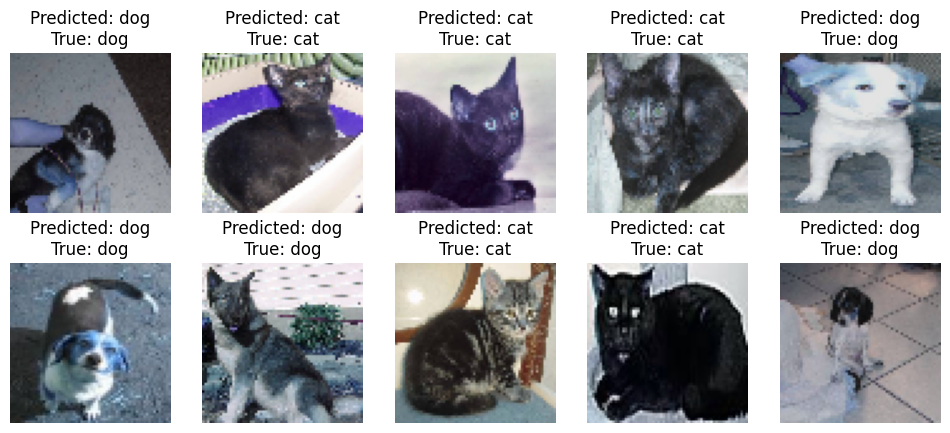

In [29]:
# visualize the result

from matplotlib import pyplot as plt

n = 10
plt.figure(figsize=(12, 5))

for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(catdog_x_test[i])
    plt.title('Predicted: {}\nTrue: {}'.format(
        list(labels_map.keys())[np.argmax(lenet5_catdog.predict(catdog_x_test[i:i+1], verbose=None))],
        list(labels_map.keys())[catdog_y_test[i]]
    ))
    plt.axis('off')

## 3. Deploy on-chain models.

Ensure your model must be a Keras model. Moreover, It should be trained before saving it on-chain. This step requires help from our development pack. Install it via pip:

In [25]:
!pip install git+https://github.com/eternalai-org/eternalai.git

  Cloning https://github.com/eternalai-org/dev-eternalai.git to c:\users\dell\appdata\local\temp\pip-req-build-_nc4rk0n
  Resolved https://github.com/eternalai-org/dev-eternalai.git to commit 506c5e3cb7e1d1a26e344b78b695dadac2df1e6a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/eternalai-org/dev-eternalai.git 'C:\Users\DELL\AppData\Local\Temp\pip-req-build-_nc4rk0n'


In [30]:
# just to make sure the installation was successful:

!eai version

2024-07-22 07:03:07 | SUCCESS  | eai.cli:main:459 - ✨ EternalAI Toolkit - Version: 1.0.2 ✨


In [27]:
# once step initialization

!eai wallet import -p <PRIVATE KEY> --network testnet

2024-07-22 11:08:43 | SUCCESS  | eai.cli:import_wallet:230 - Wallet imported and set successfully.


In [9]:
# import the toolkit 

import eai
from eai.model import Eternal

In [10]:
lenet5_mnist.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,296 (106.63 KB)

 Trainable params: 9,098 (35.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,198 (71.09 KB)

In [12]:
if eai.check(lenet5_mnist):
    lenet5_mnist_onchain_model = eai.transform(
        lenet5_mnist, 
        model_name = "lenet5_mnist_202407"
    )
else:
    print('Model is not valid, please recheck!')

2024-07-22 07:55:05 | INFO     | eai.func:check:117 - Loading model from <Sequential name=sequential, built=True> ...
2024-07-22 07:55:05 | INFO     | eai.func:check_keras_model:72 - Checking model layers ...
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 0: Layer InputLayer
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 1: Layer Conv2D
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 2: Layer MaxPooling2D
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 3: Layer Conv2D
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 4: Layer MaxPooling2D
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 5: Layer Flatten
2024-07-22 07:55:05 | SUCCESS  | eai.func:check_keras_model:83 - 6: Layer Dense
2024-07-22 07:55:05 | INFO     | eai.func:check_keras_model:108 - Summary: 7 layers supported, 0 layers not supported.
2024-07-22 07:55:05 | INFO     | eai.func:transform:41 - Transforming model on EternalAI'

2024-07-22 07:55:07 | SUCCESS  | eai.deployer:deploy_from_artifact:65 - Contract has been deployed to address 0x36142F7da1894a1411505bf346df3c36EC57b0d3, tx=0xf46c189bbd6c30eb2d0a89d5bc1424a1b7b2b17c5d62f188a293cf3728119a1c.
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 0: InputLayer, type: LayerType.InputLayer
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 1: Conv2D, type: LayerType.Conv2D
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 2: MaxPooling2D, type: LayerType.MaxPooling2D
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 3: Conv2D, type: LayerType.Conv2D
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 4: MaxPooling2D, type: LayerType.MaxPooling2D
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 5: Flatten, type: LayerType.Flatten
2024-07-22 07:55:07 | INFO     | eai.deployer:get_model_config:77 - Layer 6: Dense, type: Lay

In [13]:
if eai.check(lenet5_catdog):
    lenet5_catdog_onchain_model: Eternal = eai.transform(
        lenet5_catdog, 
        model_name = "lenet5_catdog_202407"
    )

else:
    print('Model is not valid, please recheck!')

2024-07-22 07:55:48 | INFO     | eai.func:check:117 - Loading model from <Sequential name=sequential_1, built=True> ...
2024-07-22 07:55:48 | INFO     | eai.func:check_keras_model:72 - Checking model layers ...
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 0: Layer InputLayer
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 1: Layer Conv2D
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 2: Layer MaxPooling2D
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 3: Layer Conv2D
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 4: Layer MaxPooling2D
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 5: Layer Flatten
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 6: Layer Dense
2024-07-22 07:55:48 | SUCCESS  | eai.func:check_keras_model:83 - 7: Layer Dense
2024-07-22 07:55:48 | INFO     | eai.func:check_keras_model:108 - Summary: 8 layers supported, 0 layers not supported.
2024-07

## 4. Make on-chain prediction

Ensure your `input_tensor` is preprocessed to match the model’s expected input format.

In [14]:
sample = mnist_x_test[0]
print(sample.shape)
print(sample.dtype)

(28, 28, 1)
float32


In [16]:
output_tensor = lenet5_mnist_onchain_model.predict([sample])
print('Predicted:', mnist_labels[np.argmax(output_tensor)])

2024-07-22 07:59:53 | INFO     | eai.model:predict:140 - Making prediction on EternalAI's testnet at 0x36142F7da1894a1411505bf346df3c36EC57b0d3 ...
2024-07-22 07:59:59 | SUCCESS  | eai.model:predict:153 - Prediction made successfully in 6.217206239700317 seconds. Output: [[0.0, 0.0, 1.3969838619232178e-09, 2.2817403078079224e-08, 0.0, 1.3969838619232178e-09, 0.0, 1.0, 0.0, 1.6298145055770874e-09]]
Predicted: 7


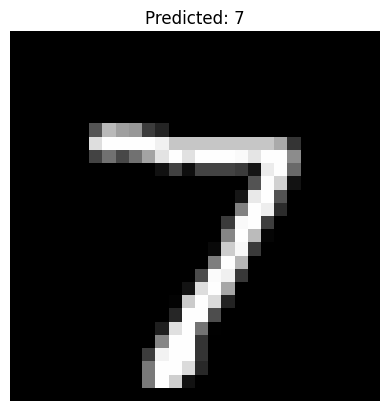

In [19]:
# let's check
plt.imshow(sample, cmap='gray')
plt.title('Predicted: {}'.format(mnist_labels[np.argmax(output_tensor)]))
plt.axis('off')
plt.show()